# Week 2 Assignment: Text Vectorization

Overview:

This assignment involves applying preprocessing techniques and classical vectorization methods to the SMS Spam Dataset. Students will build a preprocessing pipeline, vectorize the text using various methods, and evaluate the impact on a classification task (spam vs. ham).
In addition to vectorization, students must analyze the sparsity and feature space dimensions of their models to evaluate computational efficiency

Submission Requirements   
	•	Code: Submit a single Jupyter Notebook containing all the Python code.    
	•	Analysis: Include written responses to all analytical prompts in markdown cells within the notebook.    
	•	Visualization: Include all required plots and charts in the notebook.   
	•	Filename: Name the file as
			Week2_Textvectorization_<YourName>.pdf



In [193]:
import pandas as pd

# URL for the SMS Spam Dataset
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"

# Load the dataset
sms_data = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

# Display the first few rows
print("First 5 rows of the SMS Spam Dataset:")
print(sms_data.head())

# Check dataset size
print("\nDataset Size:", sms_data.shape)

# Split dataset into spam and ham categories for exploration
print("\nLabel Distribution:")
print(sms_data['label'].value_counts())

First 5 rows of the SMS Spam Dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Dataset Size: (5572, 2)

Label Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


## Part 1: preprocessing (20 points)


	1.	Task:   
	•	Preprocess the SMS Spam dataset:
			•	Tokenize the text.
			•	Apply stemming (Porter or Snowball) and lemmatization.
			•	Remove special characters, numbers, and URLs.
	•	Create a reusable preprocessing pipeline.
	•	Justify whether stemming or lemmatization is more appropriate for maintaining the semantic integrity of SMS-style language (e.g., 'u', 'r', 'gr8').

	2.	Deliverable (15 points):
	•	Python code implementing the preprocessing pipeline
	•	Example output showing raw and preprocessed text.

	3.	Question (5 points)
	•	Beyond vocabulary size, how does the choice between stemming and lemmatization affect the sparsity of the resulting vectors in Part 2?

In [194]:
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

Get the corpus as a single text block.

In [195]:
text = " ".join(sms_data["message"].values)

Set up the generalized preprocessing function. The preprocessing steps will occur in the following order:

1. Text substitutions
    - Remove special characters, URLs, and numbers.
2. Tokenize
    - Utilize the word_tokenize nltk function to turn the text block into a list of tokens.
3. Stemming or Lemmatization
    - Perform stemming or lemmatization if either are selected.

In [196]:
def preprocess(text, stemmer:PorterStemmer|SnowballStemmer|None=None, lem:WordNetLemmatizer|None=None):
    assert not (stemmer is not None and lem is not None)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stemming
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    elif lem:
        tokens = [lem.lemmatize(token) for token in tokens]

    return " ".join(tokens)
    

Get preprocessed text without stemming or lemmatization.

In [197]:
preprocessed_text = preprocess(text)

Get preprocessed text with porter stemming.

In [198]:
porter_stemmed = preprocess(text, stemmer=PorterStemmer())

Get preprocessed text with snowball stemming.

In [199]:
snowball_stemmed = preprocess(text, stemmer=SnowballStemmer('english'))

Get preprocessed text with lemmatization.

In [200]:
lemmatized = preprocess(text, lem=WordNetLemmatizer())

Compare each preprocessing method.

In [201]:
print("\nOriginal Tokens:\n", text[:150])
print("\nPreprocessed Text Without Stemming or Lemmatization:\n", preprocessed_text[:150])
print("\nPorter Stemmed:\n", porter_stemmed[:150])
print("\nSnowball Stemmed:\n", snowball_stemmed[:150])
print("\nLemmatized:\n", lemmatized[:150])


Original Tokens:
 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... Ok lar... Joking wif u oni... Free ent

Preprocessed Text Without Stemming or Lemmatization:
 Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat Ok lar Joking wif u oni Free entry in a wkly co

Porter Stemmed:
 go until jurong point crazi avail onli in bugi n great world la e buffet cine there got amor wat ok lar joke wif u oni free entri in a wkli comp to wi

Snowball Stemmed:
 go until jurong point crazi avail onli in bugi n great world la e buffet cine there got amor wat ok lar joke wif u oni free entri in a wkli comp to wi

Lemmatized:
 Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat Ok lar Joking wif u oni Free entry in a wkly co


Lemmatization is more effective at retaining the semantic integrity of the data, as it truncates words to a dictionary root word. For English, where there are many non-standard suffixes, this is important. The semantic meaning of a given suffix on some words may be entirely different than that of other words, so arbitrarily modifying the suffix with grapheme-based rules can generate non-words or change the context of the word in a sentence. I.e. "crazi", "onli", and "avail" in the output, above. For SMS-style language, lemmatization does not transform the noisy, abbreviated versions of sms slang, so it can effectively be used in conjunction with a function to correct abbreviations. On the contrary, stemming may transform abbreviations into various configurations of the original abbreviated text, making it exceedingly difficult to capture all abbreviated words to correct.    

### **Beyond vocabulary size, how does the choice between stemming and lemmatization affect the sparsity of the resulting vectors in Part 2?**

Let's experiment and calculate sparsity for each method.

In [202]:
import numpy as np

def calculate_sparsity(matrix):
    """
    Calculates sparsity percentage of a given matrix.
    :param matrix: Sparse matrix or array
    :return: Sparsity as a percentage
    """
    # Convert the matrix to a dense array if it's sparse
    if hasattr(matrix, 'toarray'):
        matrix = matrix.toarray()
    total_elements = np.prod(matrix.shape)
    zero_elements = np.count_nonzero(matrix == 0)
    sparsity = (zero_elements / total_elements) * 100
    return sparsity

Bag of Words will be used to test the variation between preprocessing methods.

In [203]:
from sklearn.feature_extraction.text import CountVectorizer

In [204]:
bow_vectorizer = CountVectorizer(max_features=100)

#### Porter Stemming

In [205]:
bow_matrix_porter = bow_vectorizer.fit_transform([preprocess(text, stemmer=PorterStemmer()) for text in sms_data["message"].values])
print("\nBag of Words Porter Stemming Shape:", bow_matrix_porter.shape)


Bag of Words Porter Stemming Shape: (5572, 100)


#### Snowball Stemming

In [206]:
bow_matrix_snowball = bow_vectorizer.fit_transform([preprocess(text, stemmer=SnowballStemmer('english')) for text in sms_data["message"].values])
print("\nBag of Words Snowball Stemming Shape:", bow_matrix_snowball.shape)


Bag of Words Snowball Stemming Shape: (5572, 100)


#### Lemmatization

In [207]:
bow_matrix_lem = bow_vectorizer.fit_transform([preprocess(text, lem=WordNetLemmatizer()) for text in sms_data["message"].values])
print("\nBag of Words Lemmatization Shape:", bow_matrix_lem.shape)


Bag of Words Lemmatization Shape: (5572, 100)


In [208]:
print("--------------------------------------------------------")
print("|", "Porter Stemming Sparsity:\t", "|", calculate_sparsity(bow_matrix_porter), "%", "|")
print("--------------------------------------------------------")
print("|", "Snowball Stemming Sparsity:\t", "|", calculate_sparsity(bow_matrix_snowball), "%", "|")
print("--------------------------------------------------------")
print("|", "Lemmatization Sparsity:\t", "|", calculate_sparsity(bow_matrix_lem), "%", "|")
print("--------------------------------------------------------")


--------------------------------------------------------
| Porter Stemming Sparsity:	 | 94.16493180186649 % |
--------------------------------------------------------
| Snowball Stemming Sparsity:	 | 94.18305814788226 % |
--------------------------------------------------------
| Lemmatization Sparsity:	 | 94.36844938980617 % |
--------------------------------------------------------


Based on the analysis above, the sparsity of each method is marginally different. That said, porter stemming generated the least sparse dataset at 94.16% sparsity, followed by snowball stemming at 94.18% sparsity, then lemmatization with 94.37% sparsity. This is expected, as the vocabulary is reduced most with stemming, as discovered in Module 1. The larger the vocabulary, the more sparse the dataset depending on the maximum number of features allowed within the vectorizer. 

## Part 2: Vectorization (40 points)


	1.	Task:
	•	Vectorize the preprocessed text using:
			•	Bag of Words (BoW).
			•	TF-IDF.
			•	N-Grams (unigrams, bigrams, and trigrams).
	•	Compare vector sizes and sparsity across methods
	•	Calculate the total number of unique features generated for unigrams, bigrams, and trigrams separately.

	2.	Deliverable (30 points):
	•	Python code for vectorization using each method.
	•	Table summarizing vector dimensions and sparsity.

	3.	Question (10 points):
	•	What are the trade-offs between Bag of Words and TF-IDF in terms of dimensionality and interpretability?
	•	Based on the dimensionality of your N-gram vectors, discuss the 'curse of dimensionality. At what point does the benefit of context-awareness (e.g., trigrams) get outweighed by the computational cost?

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### Bag of Words

In [210]:
# Bag of Words
bow_vectorizer = CountVectorizer(max_features=500)
bow_matrix = bow_vectorizer.fit_transform([preprocess(text, lem=WordNetLemmatizer()) for text in sms_data["message"].values])

print("\nBag of Words Shape:", bow_matrix.shape)


Bag of Words Shape: (5572, 500)


#### TF-IDF

In [211]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform([preprocess(text, lem=WordNetLemmatizer()) for text in sms_data["message"].values])

print("\nTF-IDF Shape:", tfidf_matrix.shape)


TF-IDF Shape: (5572, 500)


#### N-Grams

Note, max_fatures will not be set here to see the number of features generated by each method.

##### Unigrams

In [212]:
unigram_vectorizer = CountVectorizer(ngram_range=(1,1))
unigram_matrix = unigram_vectorizer.fit_transform([preprocess(text, lem=WordNetLemmatizer()) for text in sms_data["message"].values])

print("\nUnigram Shape:", unigram_matrix.shape)


Unigram Shape: (5572, 8160)


##### Bigrams

In [213]:
bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_matrix = bigram_vectorizer.fit_transform([preprocess(text, lem=WordNetLemmatizer()) for text in sms_data["message"].values])

print("\nBigram Shape:", bigram_matrix.shape)


Bigram Shape: (5572, 39631)


##### Trigrams

In [214]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3))
trigram_matrix = trigram_vectorizer.fit_transform([preprocess(text, lem=WordNetLemmatizer()) for text in sms_data["message"].values])

print("\nTrigram Shape:", trigram_matrix.shape)


Trigram Shape: (5572, 51921)


As expected, the number of unique features grows rapidly from unigrams to trigrams as a result of the increasing number of unique two and three word combinations generated from the respective methods.

#### Evaluate Sparsity

In [215]:
# Calculate sparsity for Bag of Words and TF-IDF matrices
print("--------------------------------------------------------")
print("|", "Bag of Words Sparsity:\t", "|", calculate_sparsity(bow_matrix), "%", "|")
print("--------------------------------------------------------")
print("|", "TF-IDF Sparsity:\t\t", "|", calculate_sparsity(tfidf_matrix), "%", "|")
print("--------------------------------------------------------")
print("|", "Unigram Sparsity:\t\t", "|", calculate_sparsity(unigram_matrix), "%", "|")
print("--------------------------------------------------------")
print("|", "Bigram Sparsity:\t\t", "|", calculate_sparsity(bigram_matrix), "%", "|")
print("--------------------------------------------------------")
print("|", "Trigram Sparsity:\t\t", "|", calculate_sparsity(trigram_matrix), "%", "|")
print("--------------------------------------------------------")

--------------------------------------------------------
| Bag of Words Sparsity:	 | 98.20258435032304 % |
--------------------------------------------------------
| TF-IDF Sparsity:		 | 98.20258435032304 % |
--------------------------------------------------------
| Unigram Sparsity:		 | 99.84444060287431 % |
--------------------------------------------------------
| Bigram Sparsity:		 | 99.96809086797712 % |
--------------------------------------------------------
| Trigram Sparsity:		 | 99.97738743933316 % |
--------------------------------------------------------


**What are the trade-offs between Bag of Words and TF-IDF in terms of dimensionality and interpretability?**

Based on the sparisty calculations, above, Bag of Words and TF-IDF produce the same dimensionality when the number of allowable features are the same. Bag of Words is a more interpretable method as it is dependent on word frequency. TF-IDF applies another layer of complexity to gain the signal of a word up or down depending on its frequency in the corpus. This aids in semantic understanding in sparse datasets, but detracts from the clarity in what the model is learning on. 

**Based on the dimensionality of your N-gram vectors, discuss the 'curse of dimensionality. At what point does the benefit of context-awareness (e.g., trigrams) get outweighed by the computational cost?**

The 'curse of dimensionality' refers to the exponential growth of the data's dimensionality as the number of grams grows. A result of greater 'N' is that there is more context within the data for the model to train on, but the contextual benefit is limited by the exponential growth in both required training time and model size. Compute is not free, as indicated by the GPU-Hours often associated with training flagship LLMs. To train on vast datasets, the computational cost quickly approaches thousands to tens of millions of GPU hours on high end hardware, which is not feasible for most independent applications. Finding the optimal balance between dimensionality and context-awareness is critical to minimize training time and maximize model accuracy.

## Part 3: ML Classification Model (40 points)


	1.	Task:
	•	Build a Support two Vector Machine (SVM) classifiers: one using **BoW vectors** and one using T**F-IDF vectors**
	•	Train the model to classify messages as spam or ham.
	•	Evaluate the model using accuracy, precision, recall, and F1-score.

	2.	Deliverable (30 points):
	•	Python code for training and evaluating the model
	•	Classification report summarizing model performance
	•	Provide a side-by-side comparison table of Accuracy, Precision, Recall, and F1-score for both models

	3.	Question (10 points):
	•	TF-IDF is intended to prioritize rare but informative terms. Did the TF-IDF model outperform BoW for the 'Spam' class specifically? Why or why not?

In [216]:
# ham = 0, spam = 1
sms_data['label'] = sms_data['label'].replace('ham',0)
sms_data['label'] = sms_data['label'].replace('spam',1)

labels = np.array(sms_data['label'])
labels

C:\Users\water\AppData\Local\Temp\ipykernel_31676\1186063354.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sms_data['label'] = sms_data['label'].replace('spam',1)


array([0, 0, 1, ..., 0, 0, 0], shape=(5572,))

In [217]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [218]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split([preprocess(text, lem=WordNetLemmatizer()) for text in sms_data["message"].values], labels, test_size=0.4, random_state=42)

#### Bag of Words

In [219]:
X_train_bow = bow_vectorizer.fit_transform(X_train_raw)
X_test_bow = bow_vectorizer.transform(X_test_raw)

In [220]:
svm_classifier_bow = LinearSVC(dual=False, max_iter=10000, random_state=42)
fit_svm_classifier_bow = svm_classifier_bow.fit(X_train_bow, y_train)

In [221]:
y_pred_bow = svm_classifier_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_test, y_pred_bow)

print(f"Model Accuracy: {accuracy_bow * 100:.2f}%")

Model Accuracy: 97.85%


#### TF-IDF

In [222]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

In [223]:
svm_classifier_tfidf = LinearSVC(dual=False, max_iter=10000, random_state=42)
fit_svm_classifier_tfidf = svm_classifier_tfidf.fit(X_train_tfidf, y_train)

In [224]:
y_pred_tfidf = svm_classifier_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

print(f"Model Accuracy: {accuracy_tfidf * 100:.2f}%")

Model Accuracy: 98.12%


In [225]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_score
import matplotlib.pyplot as plt

In [226]:
class ModelEvaluator():
    def __init__(self, fit_model):
        self.model = fit_model
    
    def eval_model(self, X_test, y_test, labels):
        self.novel_x = X_test
        self.novel_y = y_test
        self.labels = labels
        
        self.predictions = self.model.predict(X_test)

        self.reclassified_predictions = []

        for pred in self.predictions:
            if pred >= 0.5:
                self.reclassified_predictions.append(1)
            else:
                self.reclassified_predictions.append(0)

        self.confusion_matrix = {
            'true_positive':0,
            'false_positive':0,
            'true_negative':0,
            'false_negative':0
        }

        for i, dir in enumerate(self.novel_y):
            if self.reclassified_predictions[i] == 1 and dir == 0:
                self.confusion_matrix['false_positive']+=1
            elif self.reclassified_predictions[i] == 1 and dir == 1:
                self.confusion_matrix['true_positive']+=1
            elif self.reclassified_predictions[i] == 0 and dir == 1:
                self.confusion_matrix['false_negative']+=1
            elif self.reclassified_predictions[i] == 0 and dir == 0:
                self.confusion_matrix['true_negative'] += 1

        self.cm_array = np.array([[self.confusion_matrix['true_negative'], self.confusion_matrix['false_positive']],
                                    [self.confusion_matrix['false_negative'], self.confusion_matrix['true_positive']]])

        self._describe_predictions()
        self._compute_metrics()
        self._plot_cm()

    def _describe_predictions(self):
        print(f'Number of {self.labels[1]} Predictions: {self.confusion_matrix[f'true_positive'] + self.confusion_matrix['false_positive']}')
        print(f'Number of {self.labels[0]} Predictions: {self.confusion_matrix['true_negative'] + self.confusion_matrix['false_negative']}')
        print(f'Percent {self.labels[1]} Predictions: {((self.confusion_matrix['true_positive'] + self.confusion_matrix['false_positive'])/len(self.novel_y))*100}')
        print(f'Percent {self.labels[0]} Predictions: {((self.confusion_matrix['true_negative'] + self.confusion_matrix['false_negative'])/len(self.novel_y))*100}')

    def _plot_cm(self):
        fig, axes = plt.subplots(1,2,figsize=(15,10))
        axes = axes.flatten()

        cm = ConfusionMatrixDisplay(
        confusion_matrix=self.cm_array,
        display_labels=self.labels
        )

        cm.plot(cmap=plt.cm.Blues,ax=axes[0])

        axes[0].set_title('Confusion Matrix')
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_ylabel('True Label')


        axes[1].plot(self.fpr, self.tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {self.auc:.2f})')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
        axes[1].legend(loc="lower right")
        axes[1].grid(True)

        plt.show()

    def _compute_metrics(self):
        # Calculate the ROC curve points
        self.fpr, self.tpr, self.thresholds = roc_curve(self.novel_y, self.predictions)

        # Calculate the AUC
        self.auc = roc_auc_score(self.novel_y, self.predictions)

        self.accuracy = f'{accuracy_score(self.novel_y, self.reclassified_predictions)*100:.2f}%'

        # Compute recall
        self.recall = self.confusion_matrix['true_positive'] / (self.confusion_matrix['true_positive'] + self.confusion_matrix['false_negative'])

        # Compute precision
        self.precision = precision_score(self.novel_y, self.reclassified_predictions)

        # Compute F1-Score
        self.f1_score = f'{(2*self.precision*self.recall)/(self.precision+self.recall):.2f}'

        print(f'\nAccuracy: {self.accuracy}')
        print(f'\nRecall: {self.recall}')
        print(f'\nPrecision: {self.precision}')
        print(f'\nF1-Score: {self.f1_score}')

#### Bag of Words Evaluation

Number of Spam Predictions: 287
Number of ham Predictions: 1942
Percent Spam Predictions: 12.875729026469267
Percent ham Predictions: 87.12427097353073

Accuracy: 97.85%

Recall: 0.9106529209621993

Precision: 0.9233449477351916

F1-Score: 0.92


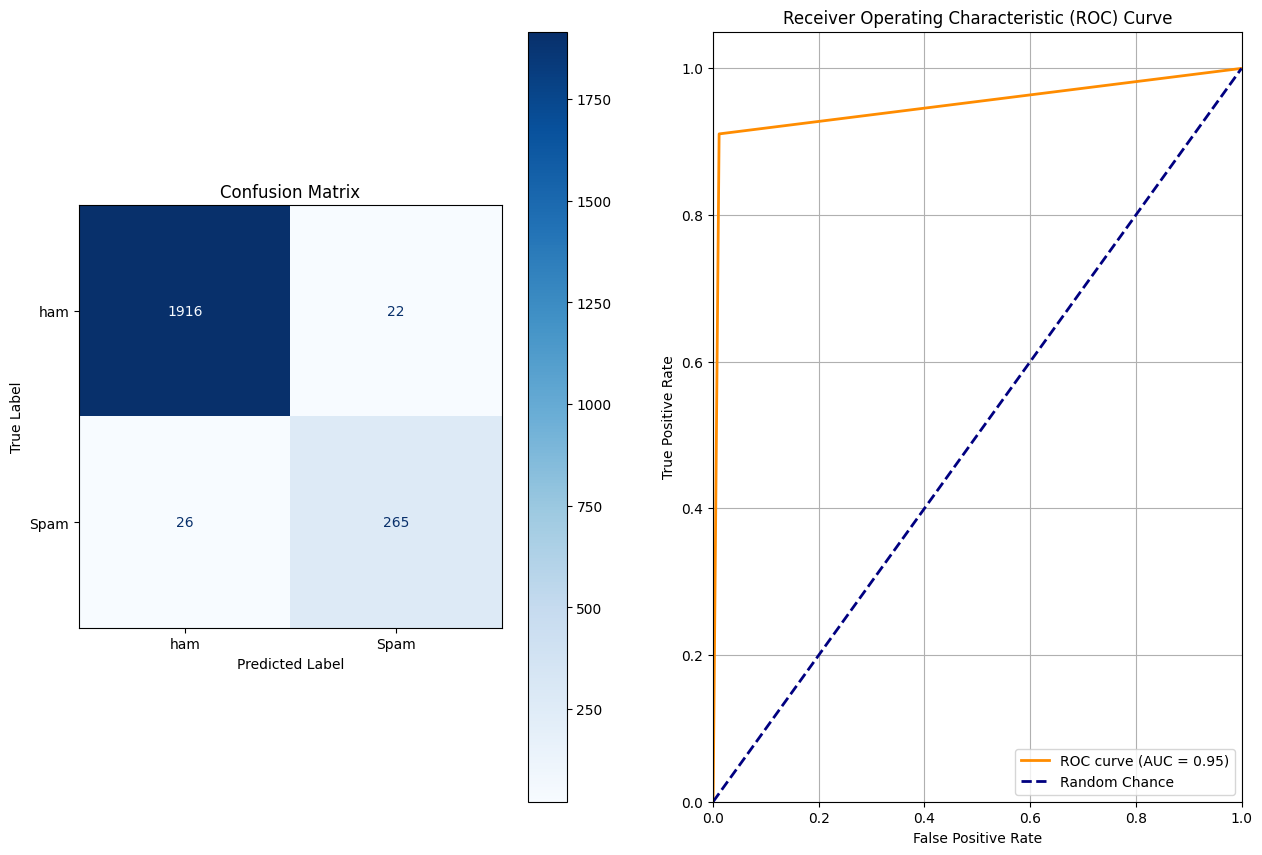

In [227]:
labels = ['ham', 'Spam']
bow_evaluator = ModelEvaluator(fit_svm_classifier_bow)
bow_evaluator.eval_model(X_test_bow, y_test, labels)

#### TF-IDF Evaluation

Number of Spam Predictions: 281
Number of ham Predictions: 1948
Percent Spam Predictions: 12.606550022431584
Percent ham Predictions: 87.39344997756842

Accuracy: 98.12%

Recall: 0.9106529209621993

Precision: 0.9430604982206405

F1-Score: 0.93


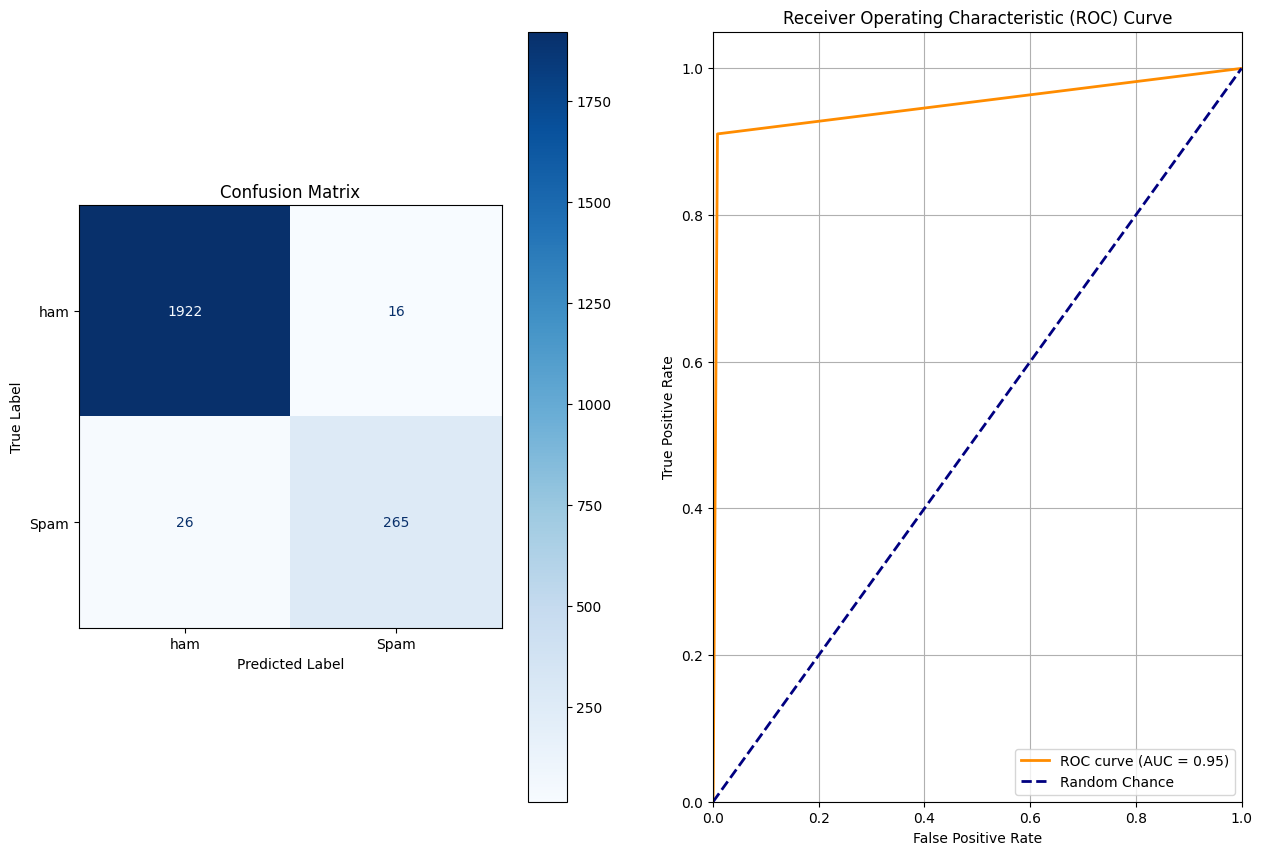

In [228]:
tfidf_evaluator = ModelEvaluator(fit_svm_classifier_tfidf)
tfidf_evaluator.eval_model(X_test_tfidf, y_test, labels)

**TF-IDF is intended to prioritize rare but informative terms. Did the TF-IDF model outperform BoW for the 'Spam' class specifically? Why or why not?**

TF-IDF did marginally outperform BoW on all metrics, but it made the same number of correct 'Spam' predictions as BoW. I believe there are two reasons for this:

1. The dataset is quite sparse for both approaches, and TF-IDF performs better on sparse data due to its signal gaining properties.
2. The "Spam" label represented about 1/10th of the data, so TF-IDF was better suited for identifying the words that correlate with this low frequency term. Although marginal, TF-IDF falsely predicted "Spam" less often than BoW, but both models equally falsely predicted "ham" instead of "Spam."